**Assignment 10 - Flight Price Dataset**

Author: Ana Tupa

Date: April 12, 2025

This script analyzes the Flight Price dataset, performs exploratory data analysis (EDA), and answers key questions about the dataset, missing data handling, feature engineering, trends and correlation analysis.



In [706]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from datetime import datetime
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Q1. Load the flight price dataset and examine its dimensions. How many rows and columns does the dataset have?

  The flight price dataset has 11 columns and 10,682 rows.

In [707]:
# Load the flight price dataset and examine its dimensions.
df=pd.read_csv('flight_price.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB




---

**Before answering the next questions, let’s take a moment to clean up our dataset!**

In [708]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


**Handle missing values:**

In [709]:
# Check for missing values
print(df.isnull().sum())

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


In [710]:
# Checking the lines where is the missing data to find if we can fill the column 'Total_Stops' with 'Route'
missing_row = df[df['Route'].isnull()]
print(missing_row)

        Airline Date_of_Journey Source Destination Route Dep_Time  \
9039  Air India       6/05/2019  Delhi      Cochin   NaN    09:45   

      Arrival_Time Duration Total_Stops Additional_Info  Price  
9039  09:25 07 May  23h 40m         NaN         No info   7480  


In [711]:
# The missing data is in the same row, it is preferible delete it before guest.
df.dropna(subset=['Route', 'Total_Stops'], inplace=True)

**Handle duplicates**

In [712]:
# Checking the duplicates
df.duplicated().sum()

np.int64(220)

In [713]:
# Dropinng duplicates
df.drop_duplicates(inplace=True)

**Correcting formatting**

In [714]:
# Converting object to datetime
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

# Convert Dep_Time (HH:MM) to standardized HH:MM format
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.strftime('%H:%M')

# Clean Arrival_Time by extracting only the HH:MM part and standardize it
df['Arrival_Time'] = df['Arrival_Time'].str.extract(r'(\d{2}:\d{2})')
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'], format='%H:%M').dt.strftime('%H:%M')

# Converting duration to total minutes:
def duration_to_minutes(duration):
    hours = 0
    minutes = 0
    if 'h' in duration:
        hours = int(duration.split('h')[0].strip())
    if 'm' in duration:
        minutes = int(duration.split('h')[1].replace('m', '').strip()) if 'h' in duration else int(duration.split('m')[0].strip())
    return hours * 60 + minutes

# Replace 'Duration' column with total minutes
df['Duration'] = df['Duration'].apply(duration_to_minutes)

# Ensuring that prices are correct
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')



**Feature Engineering**

In [715]:
unique_stops = df['Total_Stops'].unique()

print("Unique Total_Stop:", unique_stops)

Unique Total_Stop: ['non-stop' '2 stops' '1 stop' '3 stops' '4 stops']


**Validate Data Consistency**

In [716]:
df.describe()

,Date_of_Journey,Duration,Price
count,10462,10462.000000,10462.000000
mean,2019-05-04 13:38:33.056776960,629.781591,9026.790289
min,2019-03-01 00:00:00,5.000000,1759.000000
25%,2019-03-27 00:00:00,170.000000,5224.000000
50%,2019-05-15 00:00:00,505.000000,8266.000000
75%,2019-06-06 00:00:00,910.000000,12344.750000
max,2019-06-27 00:00:00,2860.000000,79512.000000
std,NaN,500.699045,4624.849541


In [717]:
# Check for unrealistic durations (e.g., negative or zero duration)
unrealistic_durations = df[df['Duration'] <= 30]
unrealistic_durations

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6474,Air India,2019-03-06,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5,2 stops,No info,17327


In [718]:
# drop this column
df.drop(index=unrealistic_durations.index, inplace=True)

In [719]:
# Check for negative values in the 'Price' column
negative_prices = df[df['Price'] < 0]
negative_prices

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price


In [720]:
# Check for unique values and inconsistencies in the columns 'Source' and 'Destination'

# List unique values in the 'Source' and 'Destination' columns
unique_sources = df['Source'].unique()
unique_destinations = df['Destination'].unique()

print("Unique Sources:", unique_sources)
print("Unique Destinations:", unique_destinations)

Unique Sources: ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
Unique Destinations: ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']


**Remove Irrelevant Columns**

After the analysis it is necessary drop the next columns: Route (Redundant if Total_Stops and times are present) and Additional_Info.

In [721]:
# Check value counts
print(df['Additional_Info'].value_counts())

Additional_Info
No info                         8181
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64


In [722]:
print(df['Route'].nunique())

128


In [723]:
# Dropping columns
df.drop(columns=['Route', 'Additional_Info'], inplace=True)

**Encoding**

In [724]:
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit and transform the 'Total_Stops' column to encode text values into numeric labels
df['Total_Stops'] = encoder.fit_transform(df['Total_Stops'])

**Outliers**

In [725]:
# We will not assess the duplicates in this point because we have a question in the point 5 about it.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10461 entries, 0 to 10682
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10461 non-null  object        
 1   Date_of_Journey  10461 non-null  datetime64[ns]
 2   Source           10461 non-null  object        
 3   Destination      10461 non-null  object        
 4   Dep_Time         10461 non-null  object        
 5   Arrival_Time     10461 non-null  object        
 6   Duration         10461 non-null  int64         
 7   Total_Stops      10461 non-null  int64         
 8   Price            10461 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 817.3+ KB


In [726]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,22:20,01:10,170,4,3897
1,Air India,2019-05-01,Kolkata,Banglore,05:50,13:15,445,1,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,09:25,04:25,1140,1,13882
3,IndiGo,2019-05-12,Kolkata,Banglore,18:05,23:30,325,0,6218
4,IndiGo,2019-03-01,Banglore,New Delhi,16:50,21:35,285,0,13302




---


# Q2. What is the distribution of flight prices in the dataset? Create a histogram to visualize the distribution.

  The prices of flights are right-skewed, meaning that most of the flights are in the low price category, with relatively fewer flights costing much more. What this implies is that cheaper flights are more common, with some expensive outliers too.

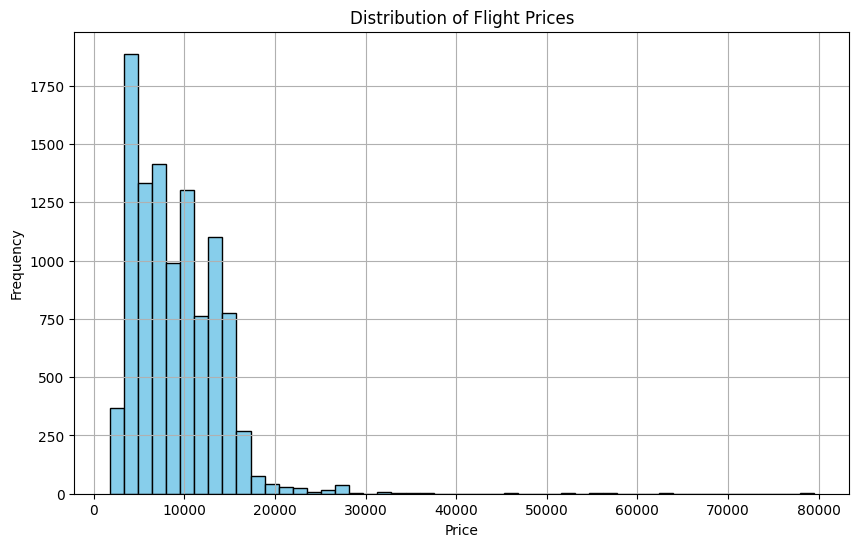

In [727]:
# Drawing an histogram to visualize the distribution.
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Flight Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Q3. What is the range of prices in the dataset? What is the minimum and maximum price?

  Acoording to the descriptive statistics, the lowest price is 1,759 and the highest price is 79,512.

  Therefore, the range of flight prices is 77,753.

In [728]:
print("Min Price:", df['Price'].min())
print("Max Price:", df['Price'].max())

Min Price: 1759
Max Price: 79512


# Q4. How does the price of flights vary by airline? Create a boxplot to compare the prices of different airlines.The boxplot illustrates that flight prices vary significantly across different airlines.

  Jet Airways Business offers the maximum median fare along with an extensive interquartile range (IQR), which reflects more base fares in addition to larger price spread. Similarly, Vistara Premium Economy and Multiple Carriers both exhibit considerably higher fares as well as bigger distributions.

  On the contrary, Trujet has the most uniform and lowest prices with a small IQR.  

  Finally, budget carriers such as IndiGo, SpiceJet, and Air Asia are cheaper options and have lower median prices and lower range.

In [729]:
df.describe()

,Date_of_Journey,Duration,Total_Stops,Price
count,10461,10461.000000,10461.000000,10461.000000
mean,2019-05-04 13:46:45.047318784,629.841315,1.463149,9025.996845
min,2019-03-01 00:00:00,75.000000,0.000000,1759.000000
25%,2019-03-27 00:00:00,170.000000,0.000000,5224.000000
50%,2019-05-15 00:00:00,505.000000,0.000000,8266.000000
75%,2019-06-06 00:00:00,910.000000,4.000000,12341.000000
max,2019-06-27 00:00:00,2860.000000,4.000000,79512.000000
std,NaN,500.685709,1.821453,4624.358456


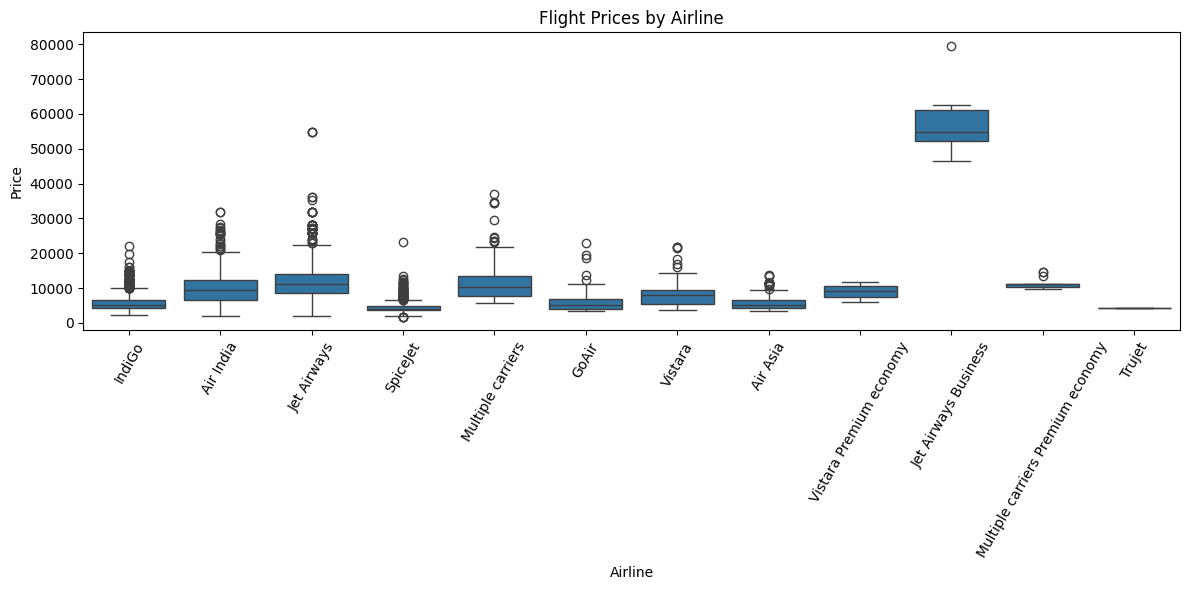

In [730]:
# Create a boxplot to compare the prices of different airlines.
plt.figure(figsize=(12, 6))
sns.boxplot(x='Airline', y='Price', data=df)
plt.title('Flight Prices by Airline')
plt.xticks(rotation=60)
plt.ylabel('Price')
plt.xlabel('Airline')
plt.tight_layout()
plt.show()

# Q5. Are there any outliers in the dataset? Identify any potential outliers using a boxplot and describe how they may impact your analysis.

Yes, the dataset contains statistical outliers, particularly in the Price, Duration, and Total_Stops columns, as observed in the boxplots. These outliers are values that fall significantly above the upper whiskers, indicating unusually high data points compared to the rest of the distribution.

Impact on the Analysis:

Descriptive Statistics: Outliers can skew the mean, inflating the average and potentially misrepresenting the central tendency of the data. This leads to a less accurate understanding of typical customer behavior or service performance.

Data Visualization: Extreme values can distort scale in plots like histograms or scatter plots, making it difficult to detect underlying trends or clusters in the main data group.

Predictive Modeling: Many machine learning algorithms—especially linear models and k-nearest neighbors—are sensitive to outliers. These outliers can heavily influence model coefficients and decision boundaries, reducing prediction accuracy and model robustness.

Strategic Decision-Making: Decisions based on outlier-driven results may lead to flawed insights. For example, if pricing strategies or resource allocations are based on outlier-influenced averages, the business might overestimate revenue potential or misallocate resources.
  

<Axes: xlabel='Price'>

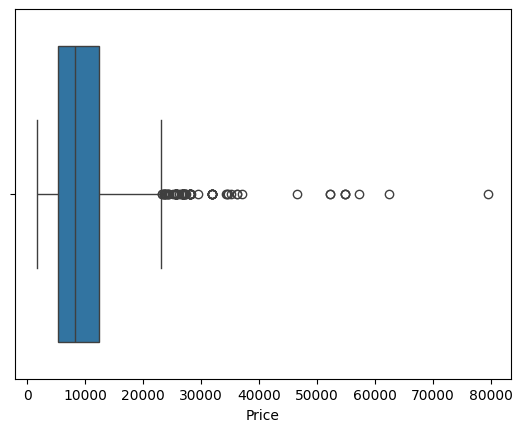

In [731]:
# Draw a boxplot for price
sns.boxplot(x=df['Price'])

<Axes: xlabel='Duration'>

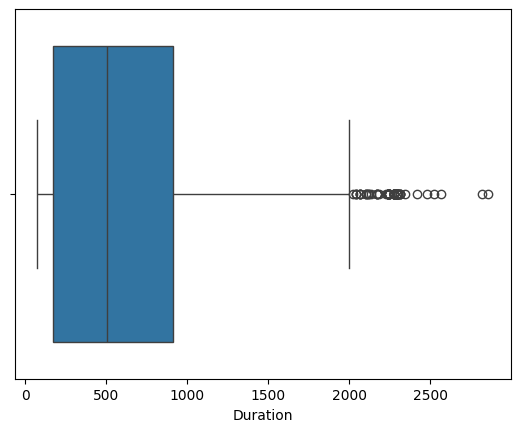

In [732]:
# Draw a boxplot for duration
sns.boxplot(x=df['Duration'])

In [733]:
# Calculating the outliers using 1.5xIQR rule

def count_outliers(df, col):
    Q1 = df[col].quantile(0.25)  # First quartile (25%)
    Q3 = df[col].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile range
    lower_limit = Q1 - 1.5 * IQR  # Lower bound
    upper_limit = Q3 + 1.5 * IQR  # Upper bound

    # Count outliers
    lower_outliers = (df[col] < lower_limit).sum()
    upper_outliers = (df[col] > upper_limit).sum()

    return lower_outliers, upper_outliers

# Define the columns to analyze
outlier_cols = ['Duration', 'Price']

# Print outlier counts for each column
for col in outlier_cols:
    lower_outliers, upper_outliers = count_outliers(df, col)
    print(f"Column: {col}")
    print(f"  - Lower outliers: {lower_outliers}")
    print(f"  - Upper outliers: {upper_outliers}")
    print(f"  - Total outliers: {lower_outliers + upper_outliers}\n")

Column: Duration
  - Lower outliers: 0
  - Upper outliers: 75
  - Total outliers: 75

Column: Price
  - Lower outliers: 0
  - Upper outliers: 94
  - Total outliers: 94





---

**Outlier Treatment Strategy**

Outlier Handling Techniques Considered:

* Remove Outliers: Eliminating outliers entirely can result in data loss and introduce bias, especially when the dataset is not extremely large. In our case, we decided not to use this option because the outliers represent high flight prices, which likely occurred for specific, meaningful reasons (e.g., holidays, demand surges). Removing them would eliminate valuable information that is crucial for accurately identifying peak seasons and understanding market behavior.

* Treat Outliers with Constants: This method consist in replace with mean or median. This can simplify the dataset but may introduce artificial values that dilute true patterns, especially in skewed distributions.

* Transform Values (e.g., Log Transformation): This is often the most effective method for skewed features like flight prices. It compresses the scale of extreme values without removing data and improves data normality.

* Separate Outliers: This approach is more suitable for small datasets or when the analysis specifically focuses on understanding the behavior of extreme cases. It's not ideal for our use case.

After analysis and research. For this stud, we don't remove the outliers in this moment we will add a column with the transformed price and duration using log transformation and compare in the analysis.

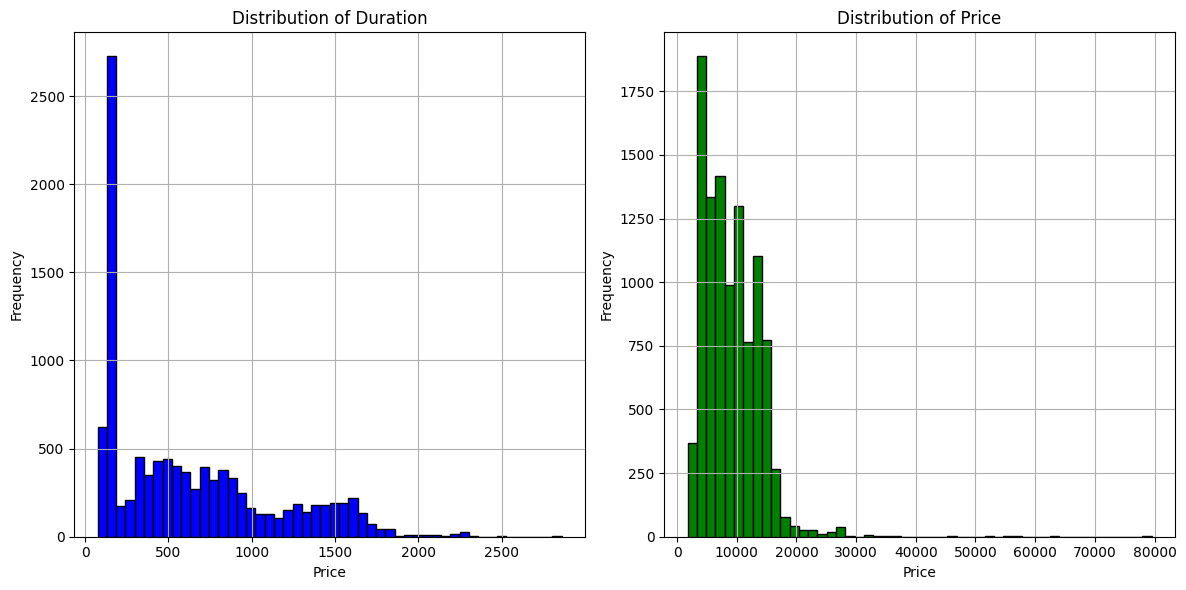

In [734]:
# Plotting the log-transformed 'Price' and 'Duration' distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Duration'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Duration')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(df['Price'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)


plt.tight_layout()
plt.show()

In [735]:
df['log_price'] = np.log1p(df['Price'])
df['Duration_log'] = np.log(df['Duration'])

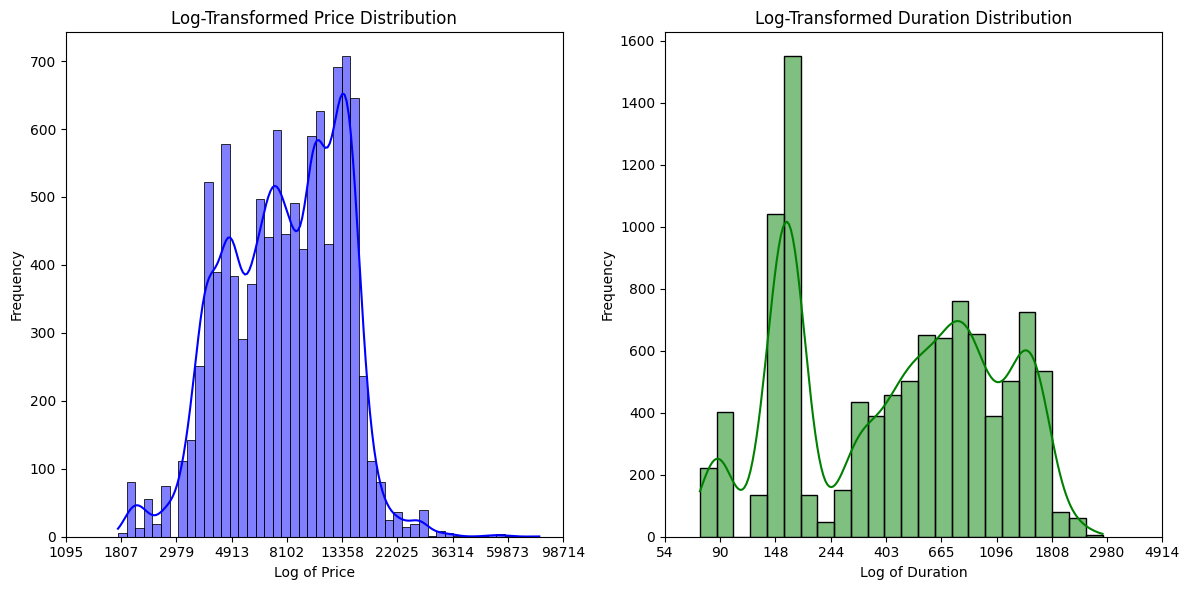

In [736]:
# Plotting the log-transformed 'Price' and 'Duration' distributions
plt.figure(figsize=(12, 6))

# Plot the log-transformed 'Price'
plt.subplot(1, 2, 1)
sns.histplot(df['log_price'], kde=True, color='blue')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log of Price')
plt.ylabel('Frequency')

# Adjusting x-axis to show the original 'Price' scale
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticks(ticks)  # Fix the tick positions
ax.set_xticklabels([f'{int(np.expm1(tick))}' for tick in ticks])

# Plot the log-transformed 'Duration'
plt.subplot(1, 2, 2)
sns.histplot(df['Duration_log'], kde=True, color='green')
plt.title('Log-Transformed Duration Distribution')
plt.xlabel('Log of Duration')
plt.ylabel('Frequency')

# Adjusting x-axis to show the original 'Duration' scale in minutes
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticks(ticks)  # Fix the tick positions
ax.set_xticklabels([f'{int(np.exp(tick))}' for tick in ticks])

plt.tight_layout()
plt.show()



---


# Q6. You are working for a travel agency, and your boss has asked you to analyze the Flight Price dataset to identify the peak travel season. What features would you analyze to identify the peak season, and how would you present your findings to your boss?

To identify the peak travel season, we focused on the following key features:
* Date_of_Journey → Extracted Month and Day of Week
* Route (Source-Destination)
* Price (Raw and Log-adjusted for skewness)
* Airline & Flight Volume

**Presentation part:**

1. Monthly Flight Volume: May and June are the peak months, with over 3,300 flights each. April has a dip, which may indicate lower demand due to fewer holidays. The agency can plan for higher resource allocation in May and June while exploring ways to boost April demand through targeted promotions or special offers.

2. Day of Week Analysis:Midweek Monday to Thursday sees the highest travel, driven by business travel. Weekends see lower travel, indicating leisure patterns. Business travel packages and promotions could be emphasized for midweek days. Conversely, leisure-focused campaigns should be developed for weekends to address lower demand.

3. Route Seasonality Routes like Delhi to Cochin and Kolkata to Bangalore are busy throughout peak months, while others like Bangalore to New Delhi saw spikes in March. Concentrate marketing efforts on the top-performing routes during peak months. For less consistent routes, like Bangalore to New Delhi, the agency should analyze whether the demand spike in March was due to a specific event or trend, and plan accordingly.

4. Price by Month: Discounts or price cuts may be provided by the agency for off-season months to stimulate demand. Alternatively, they may use dynamic price models in peak periods to generate maximum revenues while keeping demand balanced.

5. Number of Flights by Day: This chart displays daily variations in flight activity, which reflects travel demand patterns. The company can use this observation to synchronize the number of staff, maintenance schedules, and flights available. The number of additional flights can be programmed during weekdays, especially on congested business routes, and weekends can have special promotions for holidaymakers.



In [737]:
# Extract new features using 'Date_of_Journey'
df['Month'] = df['Date_of_Journey'].dt.month
df['Day'] = df['Date_of_Journey'].dt.day
df['Day_of_Week'] = df['Date_of_Journey'].dt.dayofweek  # Monday=0, Sunday=6
df['Week'] = df['Date_of_Journey'].dt.isocalendar().week

In [738]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10461 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10461 non-null  object        
 1   Date_of_Journey  10461 non-null  datetime64[ns]
 2   Source           10461 non-null  object        
 3   Destination      10461 non-null  object        
 4   Dep_Time         10461 non-null  object        
 5   Arrival_Time     10461 non-null  object        
 6   Duration         10461 non-null  int64         
 7   Total_Stops      10461 non-null  int64         
 8   Price            10461 non-null  int64         
 9   log_price        10461 non-null  float64       
 10  Duration_log     10461 non-null  float64       
 11  Month            10461 non-null  int32         
 12  Day              10461 non-null  int32         
 13  Day_of_Week      10461 non-null  int32         
 14  Week             10461 non-null  UInt32    

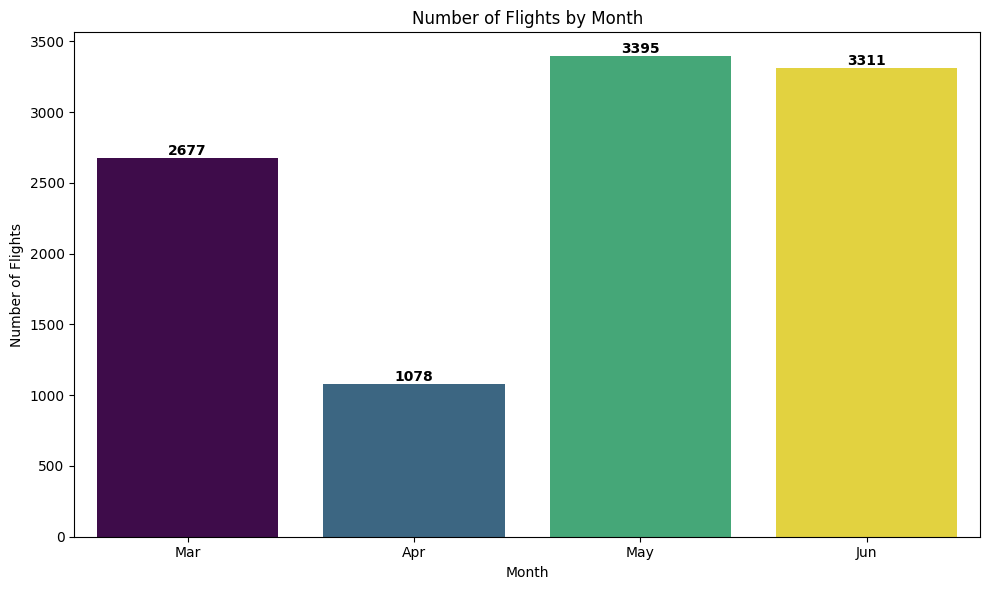

In [739]:
# Group by month and count flights
monthly_flight_count = df.groupby('Month').size().sort_index()

# Plot number of flights by month
plt.figure(figsize=(10, 6))

# Create the barplot and assign it to ax
ax = sns.barplot(
    x=monthly_flight_count.index,
    y=monthly_flight_count.values,
    hue=monthly_flight_count.index,  # To avoid the FutureWarning
    palette='viridis',
    legend=False
)

# Add exact flight count on top of each bar
for i, v in enumerate(monthly_flight_count.values):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

# Customize title and labels
plt.title('Number of Flights by Month')
plt.xlabel('Month')
plt.ylabel('Number of Flights')

# Customizing the x-ticks with month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(len(monthly_flight_count)),
           labels=[month_names[m-1] for m in monthly_flight_count.index])

plt.tight_layout()
plt.show()

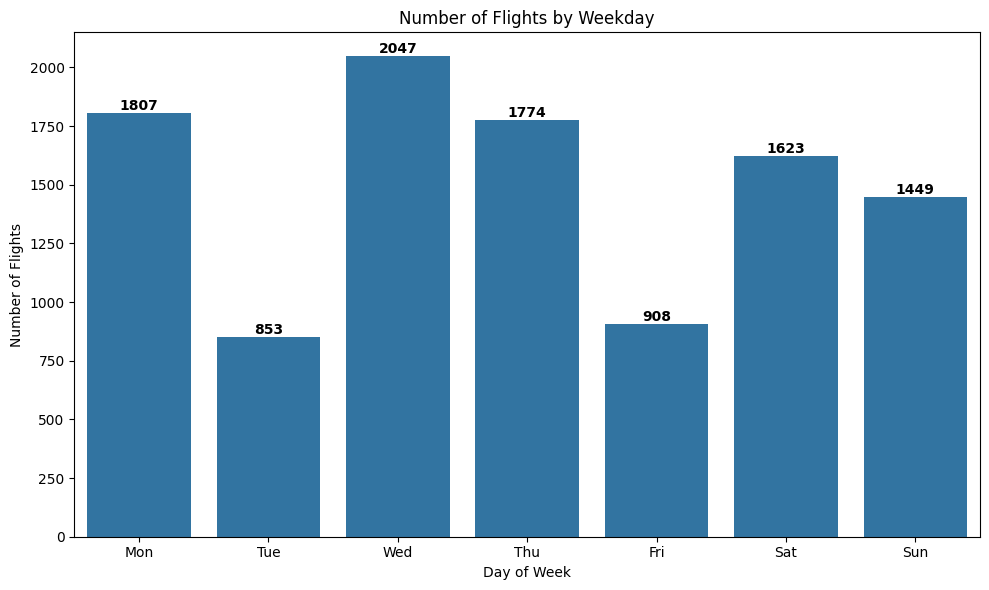

In [740]:
# Group by weekday and count the number of flights
weekday_flight_count = df.groupby('Day_of_Week').size()

# Plot number of flights by weekday
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=weekday_flight_count.index,
                 y=weekday_flight_count.values)  # No palette here

# Adding the exact number above each bar
for i, v in enumerate(weekday_flight_count.values):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

# Title and labels
plt.title('Number of Flights by Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')

# Customizing the x-ticks with weekday names
plt.xticks(ticks=range(7),
           labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

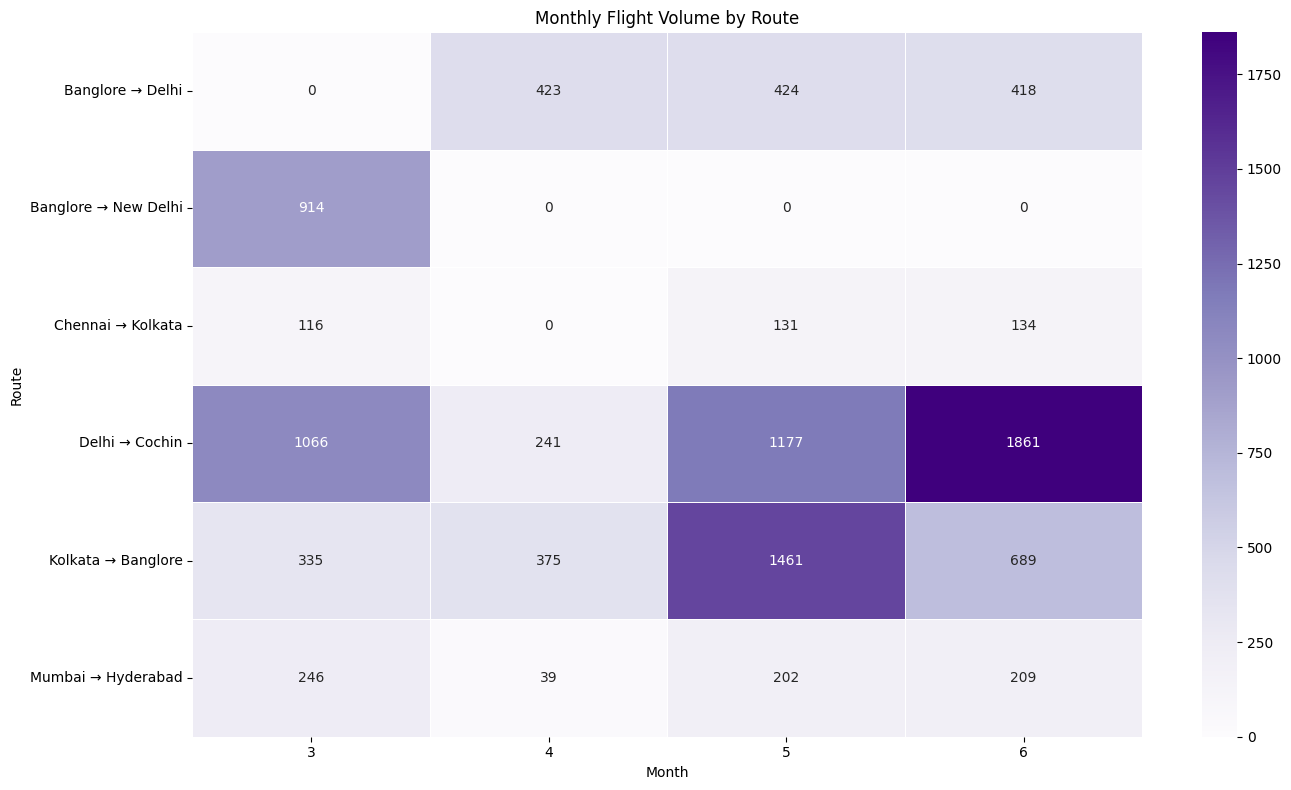

In [741]:
# Create a new column combining Source and Destination
df['Route'] = df['Source'] + ' → ' + df['Destination']

# Count number of flights per route per month
route_month_counts = df.groupby(['Route', 'Month']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(route_month_counts, annot=True, fmt='d', cmap='Purples', linewidths=.5, linecolor='white')
plt.title('Monthly Flight Volume by Route')
plt.xlabel('Month')
plt.ylabel('Route')
plt.tight_layout()
plt.show()

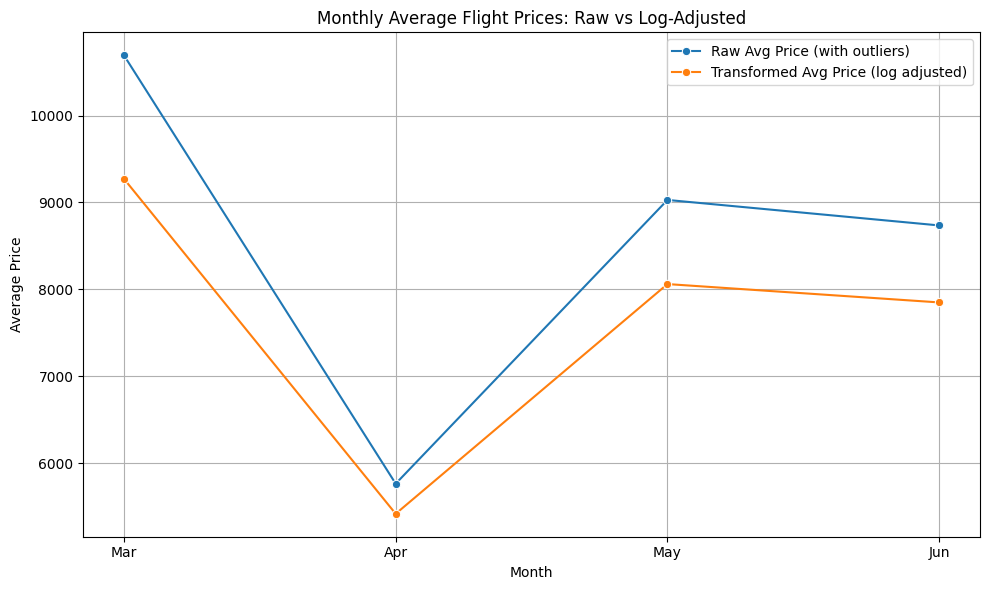

In [742]:
# Group by month
monthly_raw = df.groupby('Month')['Price'].mean().reset_index(name='Raw_Avg_Price')
monthly_log = df.groupby('Month')['log_price'].mean().reset_index(name='log_price')

# Convert log price back to real price
monthly_log['Real_Avg_Price'] = np.exp(monthly_log['log_price'])

# Merge both for combined plot
monthly_compare = pd.merge(monthly_raw, monthly_log[['Month', 'Real_Avg_Price']], on='Month')

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_compare, x='Month', y='Raw_Avg_Price', marker='o', label='Raw Avg Price (with outliers)')
sns.lineplot(data=monthly_compare, x='Month', y='Real_Avg_Price', marker='o', label='Transformed Avg Price (log adjusted)')

# Title and labels
plt.title('Monthly Average Flight Prices: Raw vs Log-Adjusted')
plt.xlabel('Month')
plt.ylabel('Average Price')

# Adjusting the x-axis ticks to display only the available months and using month_names
plt.xticks(ticks=monthly_compare['Month'], labels=[month_names[m - 1] for m in monthly_compare['Month']])

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

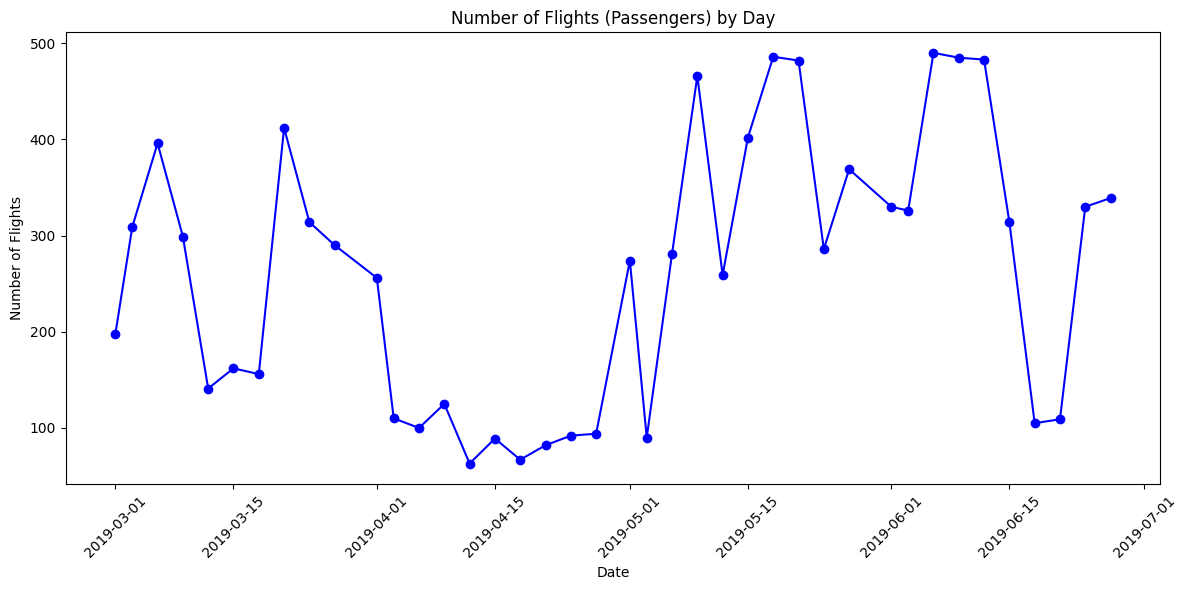

In [743]:
# Ensure Date_of_Journey is in datetime format (you've likely already done this)
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])

# Group by 'Date_of_Journey' to get the number of flights (count of rows) per day
daily_flights = df.groupby('Date_of_Journey').size()

# Plot the number of flights (or passengers) per day
plt.figure(figsize=(12, 6))
plt.plot(daily_flights.index, daily_flights.values, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Number of Flights (Passengers) by Day')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Q7. You are a data analyst for a flight booking website, and you have been asked to analyze the Flight Price dataset to identify any trends in flight prices. What features would you analyze to identify these trends, and what visualizations would you use to present your findings to your team?

To analyze flight price trends, we need to think about a few important variables. We can use a perspective of average prices and price ranges with bar plots. This will be extremely useful as the air carrier has a strong influence on the service quality and cost of operation. We can also look at routes using heatmaps to determine busy origin-destination routes and price potential.

We can also analyze the number of stops with lower prices, which can be illustrated through boxplots. Price is also influenced by time, and one can illustrate the correlation between travel time and expense in a scatter plot.

Time variables like month of year and day of week are important because there are seasonality patterns. Boxplots and heatmaps can detect highest price days and impact marketing strategy. Finally, the arrival and departure timing affects demand, and testing line plots or boxplots can determine when prices are higher or lower.

These plots determine pricing patterns and maximize flight availability adequately.


  

In [744]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10461 entries, 0 to 10682
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10461 non-null  object        
 1   Date_of_Journey  10461 non-null  datetime64[ns]
 2   Source           10461 non-null  object        
 3   Destination      10461 non-null  object        
 4   Dep_Time         10461 non-null  object        
 5   Arrival_Time     10461 non-null  object        
 6   Duration         10461 non-null  int64         
 7   Total_Stops      10461 non-null  int64         
 8   Price            10461 non-null  int64         
 9   log_price        10461 non-null  float64       
 10  Duration_log     10461 non-null  float64       
 11  Month            10461 non-null  int32         
 12  Day              10461 non-null  int32         
 13  Day_of_Week      10461 non-null  int32         
 14  Week             10461 non-null  UInt32    

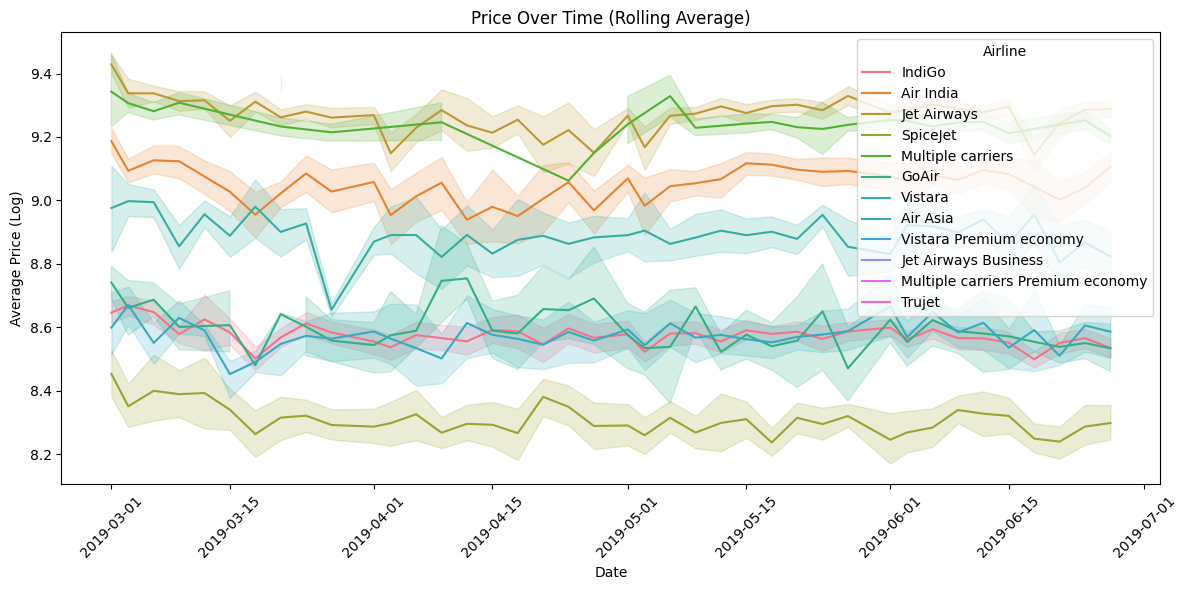

In [745]:
# Convert 'Date_of_Journey' to datetime format if not already done
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])

# Calculate rolling average price by Date_of_Journey (using a window size of 7 days for smoother trend)
df['rolling_avg_price'] = df.groupby('Airline')['log_price'].rolling(window=7).mean().reset_index(0, drop=True)

# Plot Price Over Time with rolling average
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date_of_Journey', y='rolling_avg_price', data=df, hue='Airline')
plt.title('Price Over Time (Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Average Price (Log)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

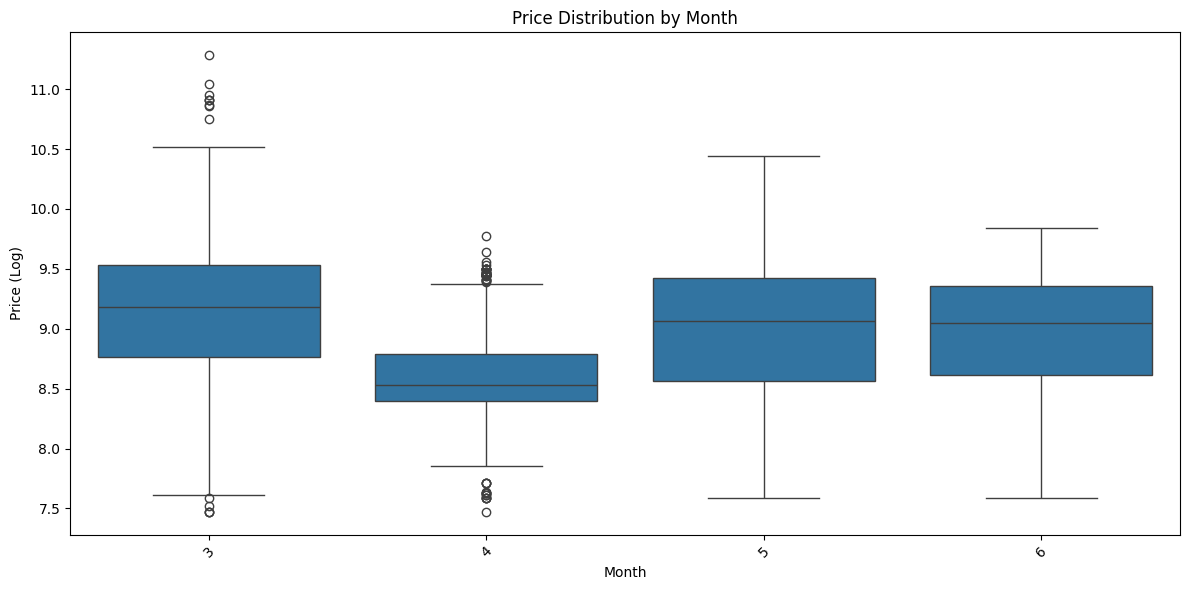

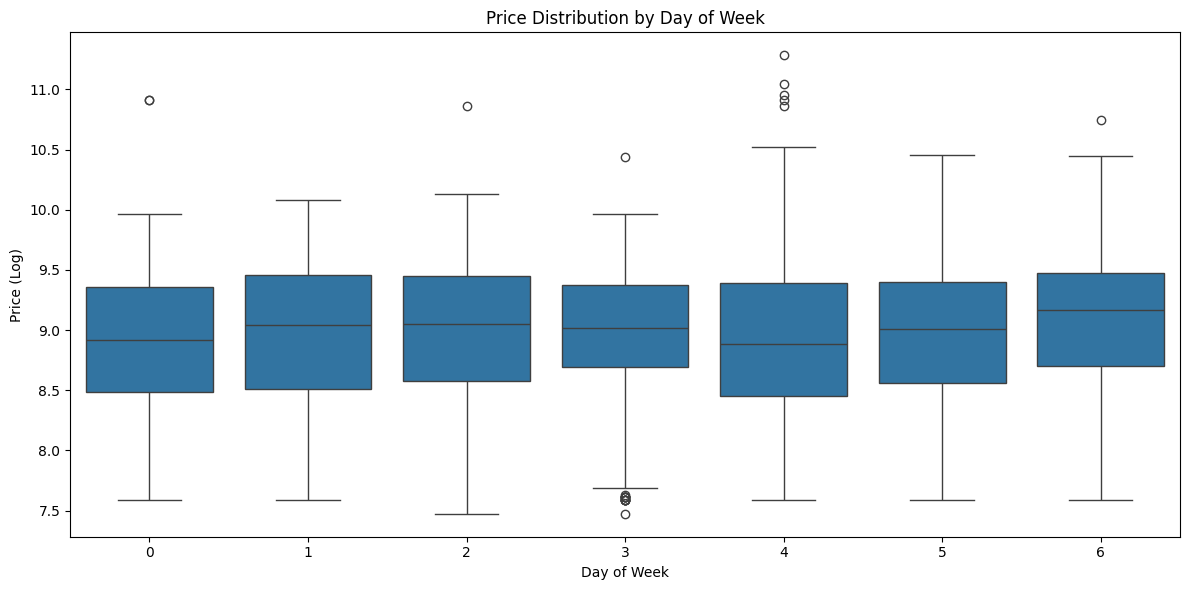

In [746]:
# Extract month and day of the week from 'Date_of_Journey'
df['Month'] = df['Date_of_Journey'].dt.month
df['Day_of_Week'] = df['Date_of_Journey'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Boxplot for price by Month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='log_price', data=df)
plt.title('Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Price (Log)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot for price by Day_of_Week
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day_of_Week', y='log_price', data=df)
plt.title('Price Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Price (Log)')
plt.tight_layout()
plt.show()

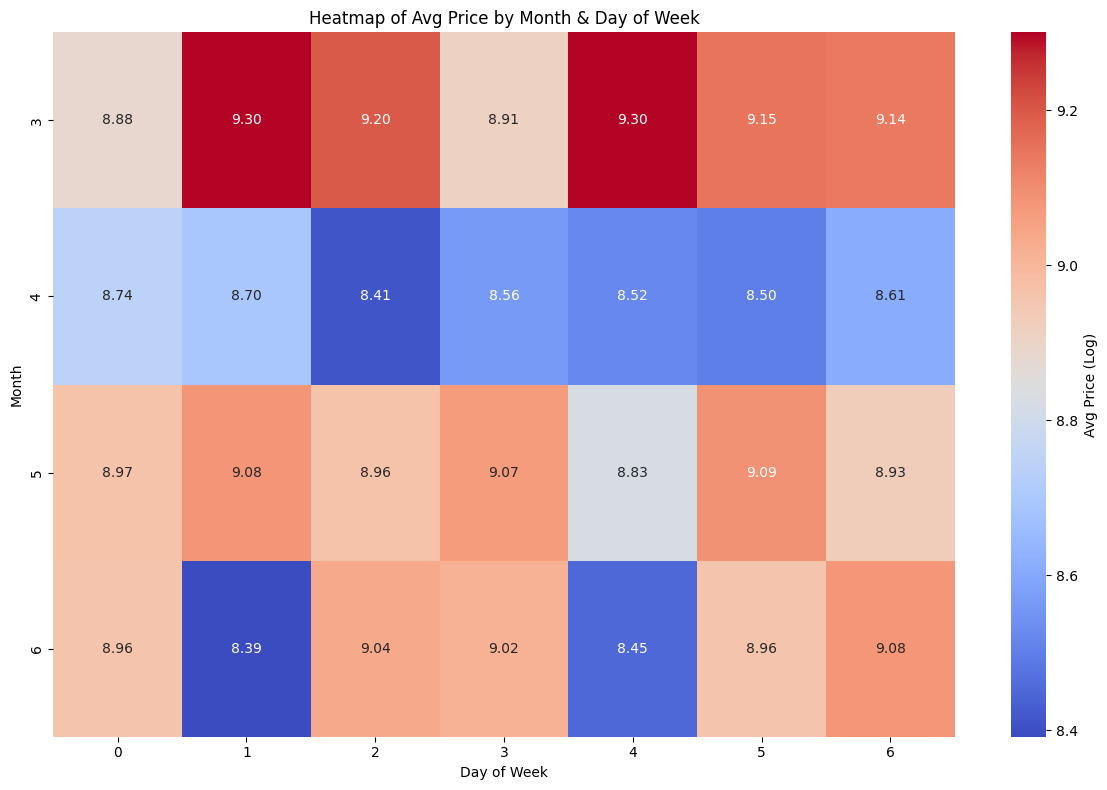

In [747]:
# Pivot data for heatmap (Avg Price by Month and Day of Week)
heatmap_data = df.groupby(['Month', 'Day_of_Week'])['log_price'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Avg Price (Log)'})
plt.title('Heatmap of Avg Price by Month & Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

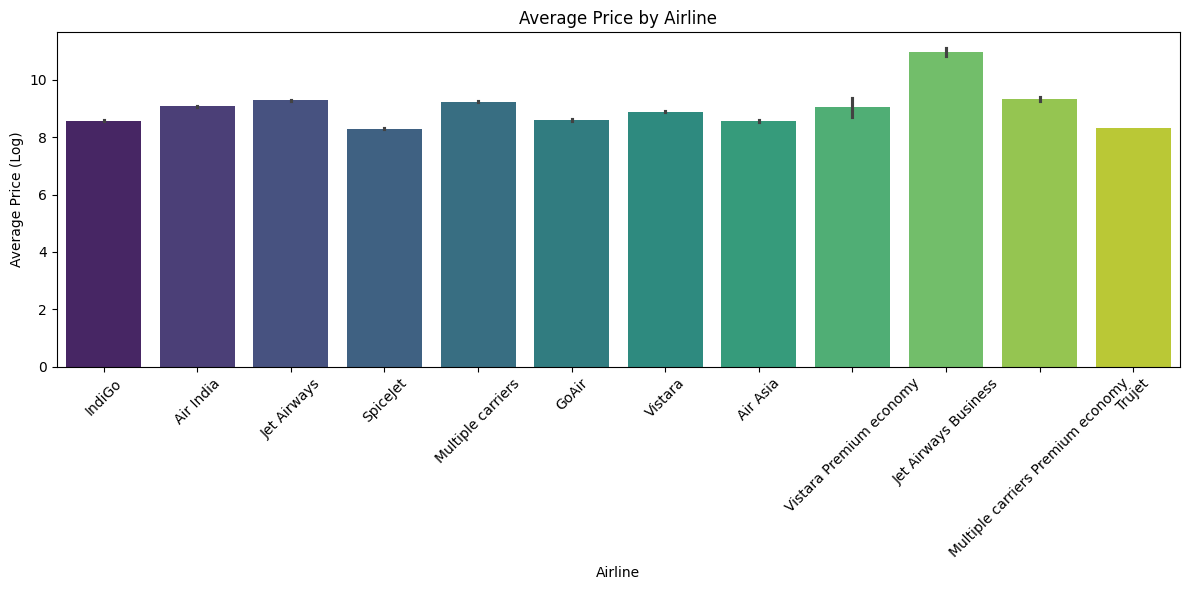

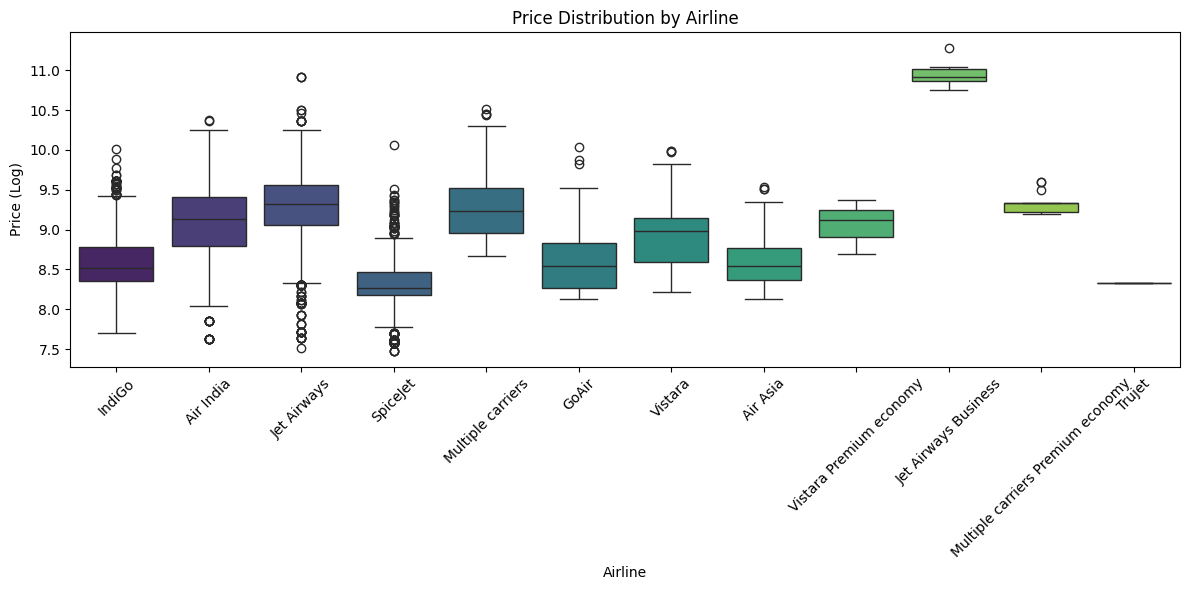

In [748]:
# Barplot of price by airline (average)
plt.figure(figsize=(12, 6))
sns.barplot(x='Airline', y='log_price', data=df, hue='Airline', palette='viridis', legend=False)
plt.title('Average Price by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Price (Log)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot of price by airline (spread)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Airline', y='log_price', data=df, hue='Airline', palette='viridis', legend=False)
plt.title('Price Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Price (Log)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

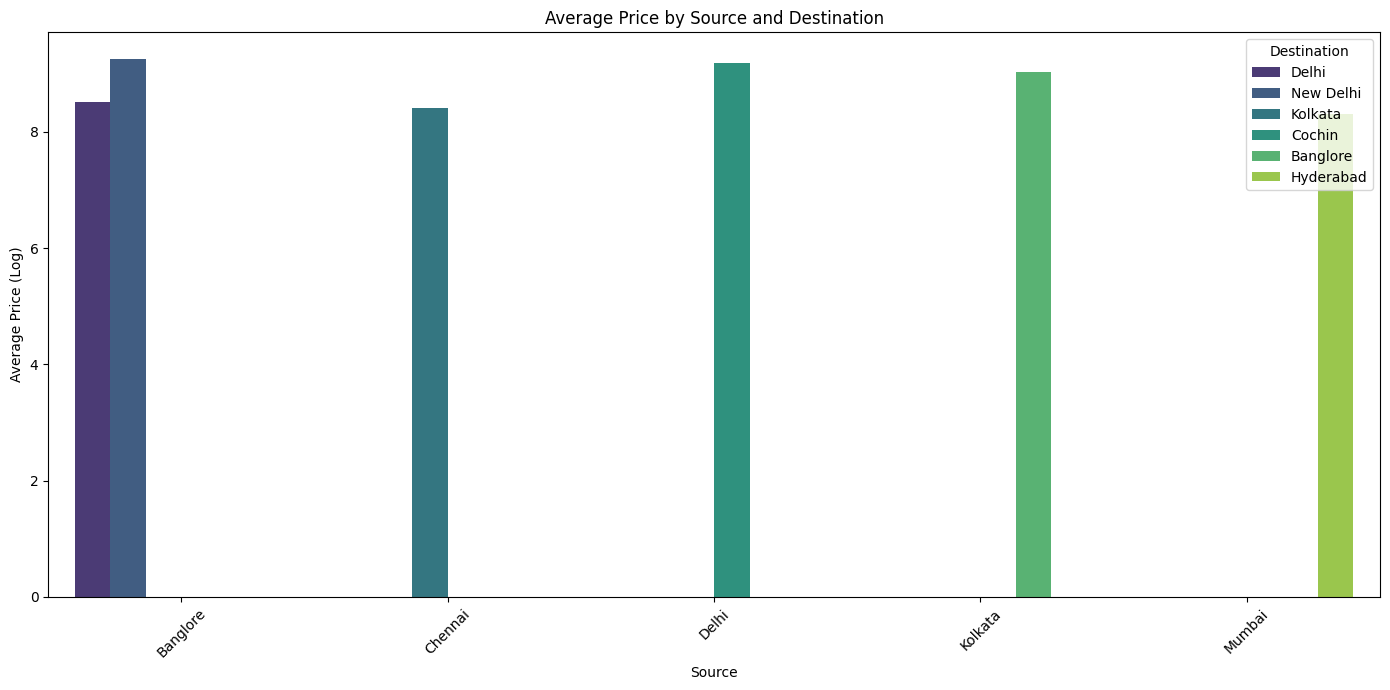

In [749]:
# Calculate average price by Source and Destination
avg_price_route = df.groupby(['Source', 'Destination'])['log_price'].mean().reset_index()

# Grouped bar chart for Source vs Destination vs Avg Price
plt.figure(figsize=(14, 7))
sns.barplot(x='Source', y='log_price', hue='Destination', data=avg_price_route, palette='viridis')
plt.title('Average Price by Source and Destination')
plt.xlabel('Source')
plt.ylabel('Average Price (Log)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

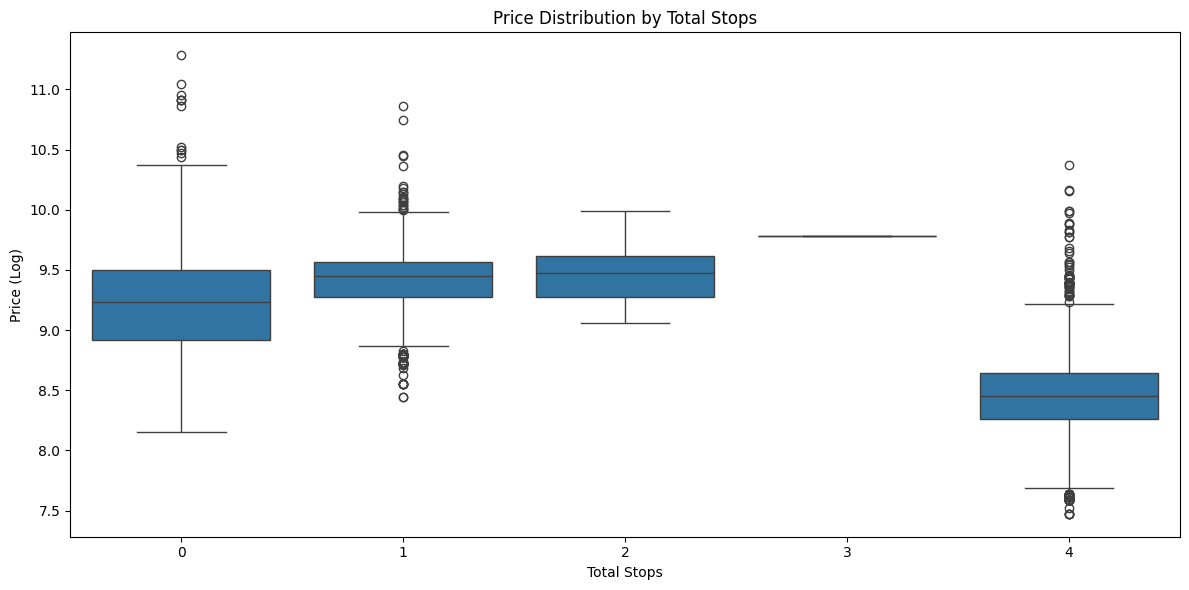

In [750]:
# Boxplot of price by total stops
plt.figure(figsize=(12, 6))
sns.boxplot(x='Total_Stops', y='log_price', data=df)
plt.title('Price Distribution by Total Stops')
plt.xlabel('Total Stops')
plt.ylabel('Price (Log)')
plt.tight_layout()
plt.show()

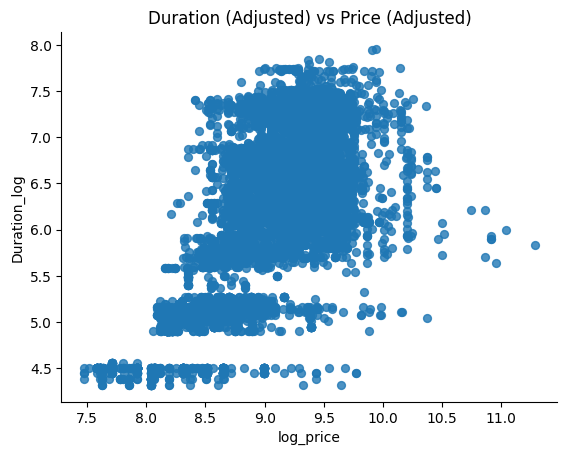

In [751]:
# Scatter plot of Duration (Adjusted) vs Price (Adjusted)
df.plot(kind='scatter', x='log_price', y='Duration_log', s=32, alpha=.8)
plt.title('Duration (Adjusted) vs Price (Adjusted)')
plt.gca().spines[['top', 'right',]].set_visible(False)

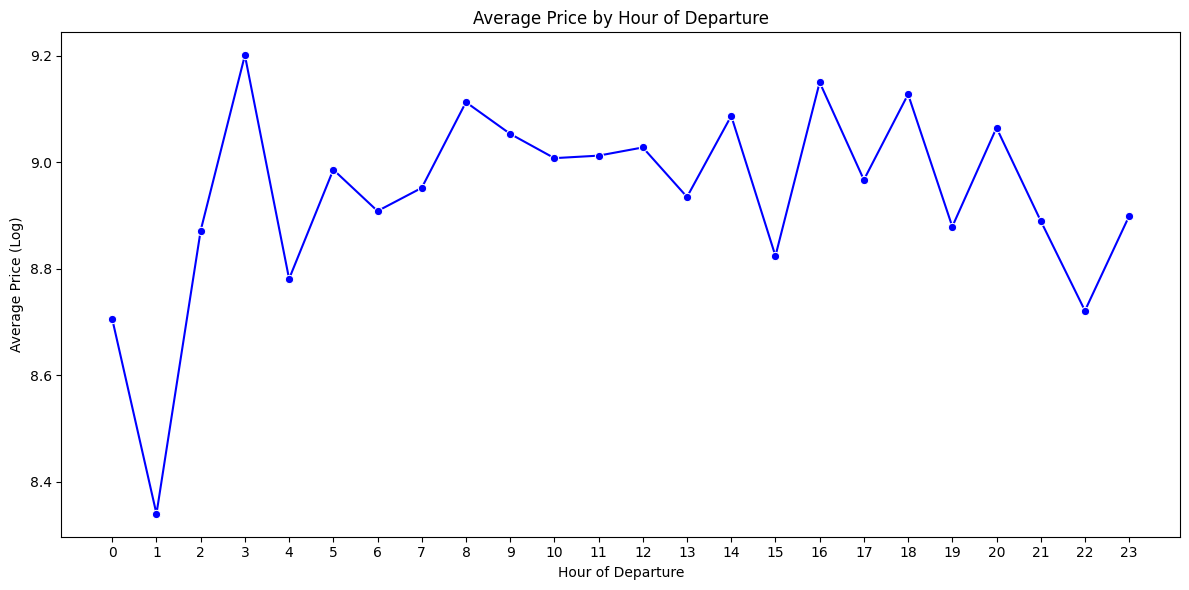

In [752]:
# Extract hour from 'Dep_Time'
df['Dep_Hour'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.hour

# Calculate average price by hour of departure
avg_price_by_hour = df.groupby('Dep_Hour')['log_price'].mean().reset_index()

# Line chart of average price by hour of departure
plt.figure(figsize=(12, 6))
sns.lineplot(x='Dep_Hour', y='log_price', data=avg_price_by_hour, marker='o', color='b')
plt.title('Average Price by Hour of Departure')
plt.xlabel('Hour of Departure')
plt.ylabel('Average Price (Log)')
plt.xticks(range(0, 24, 1))  # Set x-ticks for every hour
plt.tight_layout()
plt.show()

# Q8. You are a data scientist working for an airline company, and you have been asked to analyze the Flight Price dataset to identify the factors that affect flight prices. What features would you analyze to identify these factors, and how would you present your findings to the management team?



---
Before answer the question we need to complete the cleanning data.
* During the other analysis we add some columns that we need to delete rolling_avg_price; Date_of_Journey	Redundant we already have Month, Day, etc. Dep_Time	we have extracted Dep_Hour, Arrival_Time is not needed for this analysis, Route	is a categorical and less informative than Source + Destination;
Price because we have log_price, which reduces skew and is better for analysis
and Duration	same of price.


In [753]:
df= df.drop(columns=[
    'rolling_avg_price','Date_of_Journey', 'Dep_Time', 'Arrival_Time',
    'Route', 'Price', 'Duration'
])

In [754]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10461 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Airline       10461 non-null  object 
 1   Source        10461 non-null  object 
 2   Destination   10461 non-null  object 
 3   Total_Stops   10461 non-null  int64  
 4   log_price     10461 non-null  float64
 5   Duration_log  10461 non-null  float64
 6   Month         10461 non-null  int32  
 7   Day           10461 non-null  int32  
 8   Day_of_Week   10461 non-null  int32  
 9   Week          10461 non-null  UInt32 
 10  Dep_Hour      10461 non-null  int32  
dtypes: UInt32(1), float64(2), int32(4), int64(1), object(3)
memory usage: 1.0+ MB


In [755]:
unique_Airline = df['Airline'].unique()
unique_Source = df['Source'].unique()
unique_Source = df['Destination'].unique()

print("Unique Airline:", unique_Airline)
print("Unique Source:", unique_Source)
print("Unique Destination:", unique_Source)

Unique Airline: ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
Unique Source: ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']
Unique Destination: ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']


In [756]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for high cardinality categorical feature
categorical_cols = ['Airline']
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save encoder for potential inverse transform

# One-Hot Encoding for low cardinality categorical features
df = pd.get_dummies(df, columns=['Source', 'Destination'], drop_first=True)

In [757]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10461 entries, 0 to 10682
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Airline                10461 non-null  int64  
 1   Total_Stops            10461 non-null  int64  
 2   log_price              10461 non-null  float64
 3   Duration_log           10461 non-null  float64
 4   Month                  10461 non-null  int32  
 5   Day                    10461 non-null  int32  
 6   Day_of_Week            10461 non-null  int32  
 7   Week                   10461 non-null  UInt32 
 8   Dep_Hour               10461 non-null  int32  
 9   Source_Chennai         10461 non-null  bool   
 10  Source_Delhi           10461 non-null  bool   
 11  Source_Kolkata         10461 non-null  bool   
 12  Source_Mumbai          10461 non-null  bool   
 13  Destination_Cochin     10461 non-null  bool   
 14  Destination_Delhi      10461 non-null  bool   
 15  Destina

In [758]:
df.corr()

,Airline,Total_Stops,log_price,Duration_log,Month,Day,Day_of_Week,Week,Dep_Hour,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
Airline,1.000000,0.034368,-0.061340,-0.124757,0.025912,0.026378,-0.017742,0.032383,-0.032196,0.113324,-0.012635,-0.022377,0.006972,-0.012635,0.026856,0.006972,0.113324,-0.054973
Total_Stops,0.034368,1.000000,-0.682038,-0.810862,-0.021447,0.030251,0.039148,-0.015206,0.040325,0.270788,-0.483045,-0.114884,0.315618,-0.483045,0.516587,0.315618,0.270788,-0.030355
log_price,-0.061340,-0.682038,1.000000,0.723500,-0.072012,-0.131309,0.054541,-0.104471,-0.007578,-0.217567,0.342827,0.050935,-0.348289,0.342827,-0.337047,-0.348289,-0.217567,0.162211
Duration_log,-0.124757,-0.810862,0.723500,1.000000,0.022188,-0.031285,-0.020953,0.014756,-0.017349,-0.246034,0.404546,0.142118,-0.401612,0.404546,-0.384483,-0.401612,-0.246034,0.031300
Month,0.025912,-0.021447,-0.072012,0.022188,1.000000,-0.038459,-0.081951,0.970349,0.040496,0.006871,0.130745,0.091651,-0.037693,0.130745,0.093829,-0.037693,0.006871,-0.452456
Day,0.026378,0.030251,-0.131309,-0.031285,-0.038459,1.000000,-0.085880,0.197944,-0.003342,0.007729,0.095818,-0.057470,-0.012453,0.095818,0.004645,-0.012453,0.007729,-0.076005
Day_of_Week,-0.017742,0.039148,0.054541,-0.020953,-0.081951,-0.085880,1.000000,-0.154535,-0.013802,0.007759,-0.053120,0.034310,-0.028526,-0.053120,-0.020693,-0.028526,0.007759,0.082465
Week,0.032383,-0.015206,-0.104471,0.014756,0.970349,0.197944,-0.154535,1.000000,0.039380,0.007854,0.152771,0.073382,-0.038141,0.152771,0.094543,-0.038141,0.007854,-0.463137
Dep_Hour,-0.032196,0.040325,-0.007578,-0.017349,0.040496,-0.003342,-0.013802,0.039380,1.000000,-0.014628,-0.125243,0.160526,-0.017199,-0.125243,0.010450,-0.017199,-0.014628,-0.021991
Source_Chennai,0.113324,0.270788,-0.217567,-0.246034,0.006871,0.007729,0.007759,0.007854,-0.014628,1.000000,-0.163868,-0.119256,-0.051904,-0.163868,-0.072107,-0.051904,1.000000,-0.060155


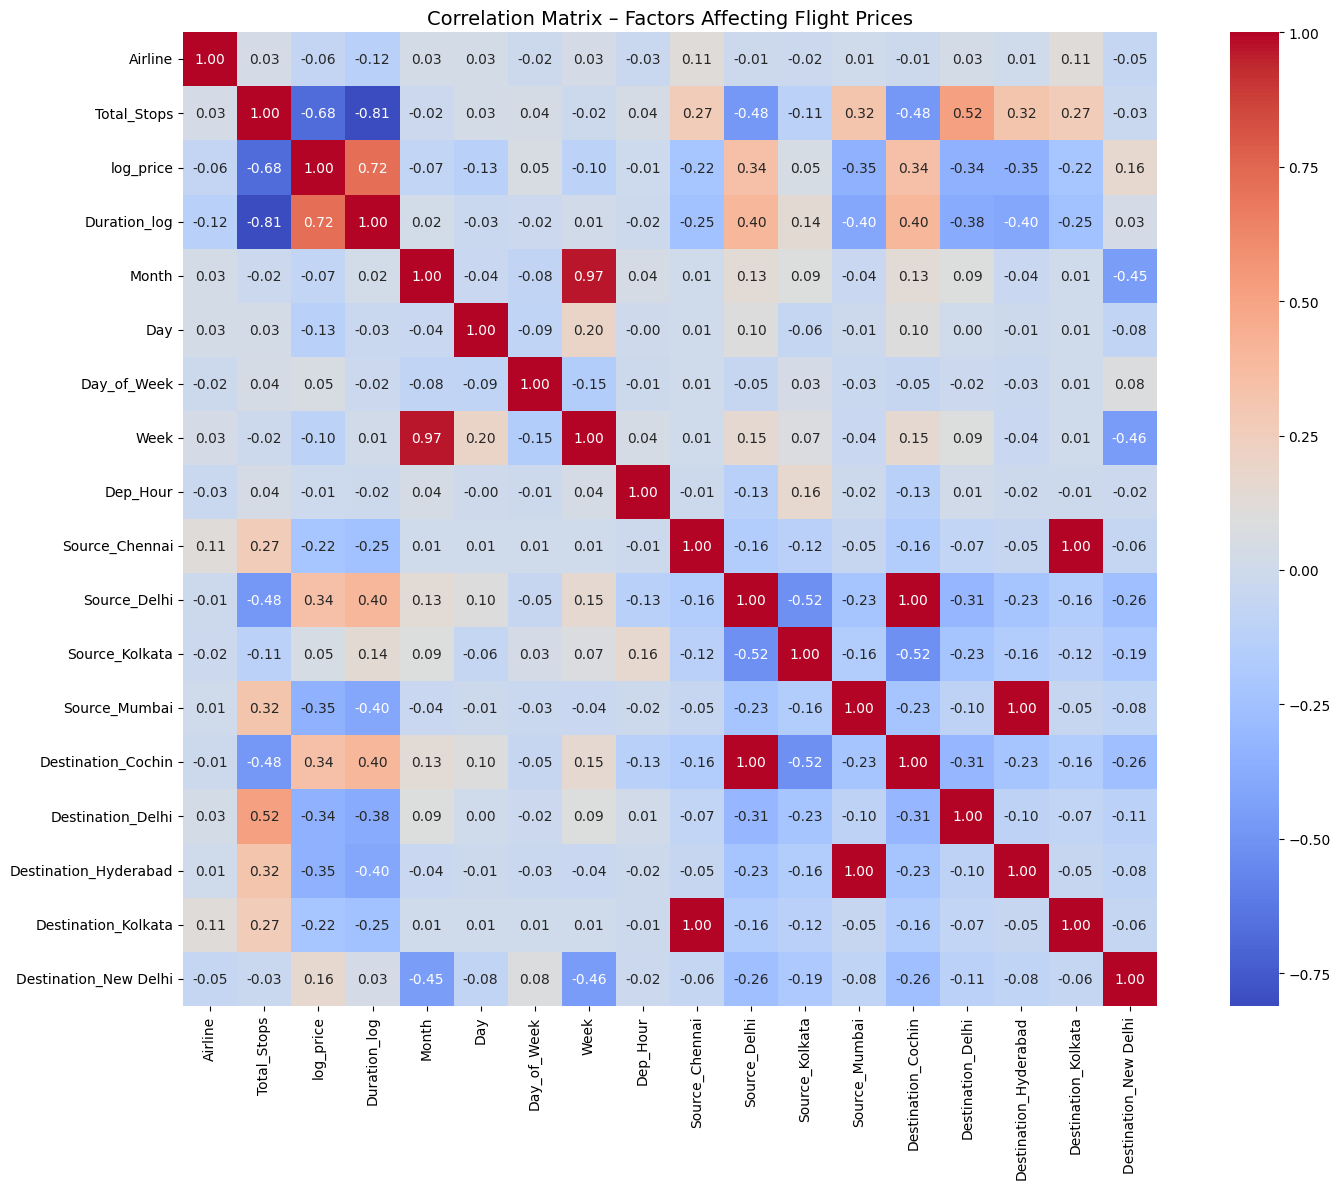

In [759]:
plt.figure(figsize=(16, 12))  # Wider and shorter
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix – Factors Affecting Flight Prices", fontsize=14)
plt.tight_layout()
plt.show()

To uncover the most important factors that affect flight prices, we analyzed the correlation of attributes with log_price. The strongest positive correlations were with Duration_log (+0.724) and Total_Stops (+0.689), which confirm that flights with longer duration and more stops are more expensive. In addition, certain routes are also relevant to pricing: Delhi-origin flights (Source_Delhi, +0.343) or flights arriving in Cochin (Destination_Cochin, +0.343) are more pricey, while Mumbai departures (Source_Mumbai, -0.348) and arrivals to destinations like Hyderabad, Kolkata, and Delhi (between -0.22 and -0.35 correlations) are associated with lower prices.

There are a couple of variables, like Month (-0.072) and Airline (-0.061), which are weakly related to price and show little linear effect individually, though possibly still having influence when combined with other variables. Additionally, Dep_Hour is related to nearly no effect, and thus departure time likely has minimal independent influence on price in this data.

When working with categorical variables like Source and Destination, which were one-hot encoded, we observed expected multicollinearity among dummy variables (e.g., Source_Delhi and Source_Mumbai). To avoid the dummy variable trap in regression models, one dummy from each category needs to be dropped—for instance, excluding Source_Mumbai from the model when others are included.

In combination, Duration_log, Total_Stops, and most significant route-level metrics are strongest predictors of flight price. Such results should be used to inform feature selection and model interpretation and provide useful background for potential pricing strategy by origin and destination.